# TO GRADER

This notebook relies on data being available that is too large to have in a github repo (13GB).

If you would like to run this notebook exactly as we used it, please download the ILSVRC2012 Validation images and recreate the file structure: "./data/imagenet/val/ILSVRC2012_img_val/". All other required metadata is available. 

Otherwise, you can see our analysis in our "analysis.ipynb" notebook.

Also, please make sure that you're creating your jupyter notebook instance inside of the 'experiments' directory.

# Imports

In [1]:
import torch
import torchvision
import numpy as np
from pathlib import Path
from glob import glob
import cv2 
import matplotlib.pyplot as plt 
from PIL import Image
import scipy.io
from tqdm import trange, tqdm
from random import shuffle

from src.alexnet import model as alexnet_model, preprocess as alexnet_preprocess
# from resnet import model as resnet_model, preprocess as resnet_preprocess
# from googlenet import model as googlenet_model, preprocess as googlenet_preprocess
from data.labels import labels

from src.simba import SimBA_Attack

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Device used: {device}")

"""
     Data loading from: 
        https://github.com/calebrob6/imagenet_validation/blob/master/\
        1.%20Preprocess%20ImageNet%20validation%20set.ipynb
"""

val_data_path = Path("./data/imagenet/val/ILSVRC2012_img_val")
val_data_labels = Path("./data/imagenet/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt")
path_synset_words = Path("./data/imagenet/ILSVRC2012_devkit_t12/data/synset_words.txt")
path_meta = Path("./data/imagenet/ILSVRC2012_devkit_t12/data/meta.mat")

/home/jkunstle/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AlexNet Loaded
Device used: cuda:0


# Utility Functions

## Get the paths of the images in the validation set

In [2]:
def get_paths():
    image_paths = sorted(glob(str(val_data_path/"*")))
    return image_paths

## Map labels to their correct values via meta.mat

In [3]:
def get_labels():
    meta = scipy.io.loadmat(str(path_meta))
    original_idx_to_synset = {}
    synset_to_name = {}

    for i in range(1000):
        ilsvrc2012_id = int(meta["synsets"][i,0][0][0][0])
        synset = meta["synsets"][i,0][1][0]
        name = meta["synsets"][i,0][2][0]
        original_idx_to_synset[ilsvrc2012_id] = synset
        synset_to_name[synset] = name

    synset_to_keras_idx = {}
    keras_idx_to_name = {}
    with open(str(path_synset_words), "r") as f:
        for idx, line in enumerate(f):
            parts = line.split(" ")
            synset_to_keras_idx[parts[0]] = idx 
            keras_idx_to_name[idx] = " ".join(parts[1:])

    convert_original_idx_to_keras_idx = lambda idx: synset_to_keras_idx[original_idx_to_synset[idx]]

    with open(str(val_data_labels),"r") as f:
        y_val = f.read().strip().split("\n")
        y_val = np.array([convert_original_idx_to_keras_idx(int(idx)) for idx in y_val])

    return y_val

## Show the input image normally and preprocessed

In [4]:
def disp_img(path):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

    im = Image.open(path)

    # alexnet preprocessing
    im_prepro = alexnet_preprocess(im)
    im_re = im_prepro.permute(1,2,0).clamp(0,1)
    plt.imshow(im_re)
    plt.show()

## Get images from path, either w/ preprocessing or not

In [5]:
def get_alexnet_img(path):
    img = Image.open(path)
    return alexnet_preprocess(img)

def get_img(path):
    return Image.open(path)

## Determine baseline model accuracy (should be roughly 56%)

In [6]:
def get_model_accuracy(model, paths, labels):
    
    """
        Shuffle the data so that we can get a different subset
        of inputs to run """
    zipped = list(zip(paths, labels))
    shuffle(zipped)
    paths, labels = zip(*zipped)
    paths, labels = list(paths), list(labels)
    
    correct = 0
    total = 0
    for i in tqdm(range(int(len(paths)/ 4))):
        this_path = paths[i]
        
        try:
            this_image = get_alexnet_img(this_path)
            
            alexnet_model.eval()
            
            with torch.no_grad():
                logits = alexnet_model(this_image.view(-1,3,224,224))
            preds = torch.nn.functional.softmax(logits, dim=1)
        except:
            continue
            
        y_hat = int(torch.argmax(preds))
        
        """
            Found that inputs that model was very confident on required
            many adversarial iterations, so picked those that it is reason-
            ably confident on but is somewhat close to the decision boundary."""
        if y_hat == labels[i]:
            correct += 1
        total += 1
        
    return correct / total

In [7]:
# percent_correct = get_model_accuracy(
#     model = alexnet_model,
#     paths = get_paths(),
#     labels = get_labels()
# )
# print(percent_correct)

## Get a random 'n' samples that the model classifies correctly

In [8]:
def find_correctly_classified(model, paths, labels, num_wanted=100):
    
    """
        Shuffle paths / labels together so we get a different set of inputs
        each time.
        
        Ref:
        https://www.geeksforgeeks.org/python-shuffle-two-lists-with-same-order/
    """
    zipped = list(zip(paths, labels))
    shuffle(zipped)
    paths, labels = zip(*zipped)
    paths, labels = list(paths), list(labels)
        
    model.eval()
    model = model.to(device)
        
    correct = []
    for i in trange(len(paths)):
        this_path = paths[i]
        
        try:
            this_image = get_alexnet_img(this_path)
            this_image = this_image.to(device)
            
            
            with torch.no_grad():
                logits = model(this_image.view(-1,3,224,224))
            preds = torch.nn.functional.softmax(logits, dim=1)
        except:
            continue
            
        y_hat = int(torch.argmax(preds))
        
        """
            Found that inputs that model was very confident on required
            many adversarial iterations, so picked those that it is reason-
            ably confident on but is somewhat close to the decision boundary."""
        if y_hat == labels[i]:
            correct += [[this_path, y_hat]]
            
        if len(correct) >= num_wanted:
            break
            
    return correct

In [9]:
correctly_classified = find_correctly_classified(
    model = alexnet_model,
    paths = get_paths(),
    labels = get_labels(),
    num_wanted = 1000
)
print("Done")

  4%|█▎                                   | 1856/50000 [00:09<04:17, 186.69it/s]

Done


## Call the SimBA Attack against images

Get the output adversarial image, the history of perturbations made on it, what its output probabilities were, whether it converged in the time that was given to it, and how many perturbations were made to it.

In [10]:
def run_simba(input_tuples, model, max_steps, epsilon):
    out_vecs = []
    for i in tqdm(input_tuples):
        path = i[0]
        label = i[1]
        
        this_img = get_alexnet_img(path)
                
        attack = SimBA_Attack(model)
        x, pert_history, last_probs, finished, count, iters = attack.simba(this_img, label, epsilon=epsilon, steps=max_steps, device=device)
        
        if finished:
            out_vecs += [[path, x, label, pert_history, count, iters]]
            
    return out_vecs

In [11]:
RUN_SIMBA = True

if RUN_SIMBA:
    out_vecs = run_simba(
        input_tuples = correctly_classified,
        model = alexnet_model,
        max_steps = 50000,
        epsilon = 0.8
    )

100%|█████████████████████████████████████| 1000/1000 [1:36:07<00:00,  5.77s/it]


## Display the most perturbed example

hand-held computer, hand-held microcomputer
353
481


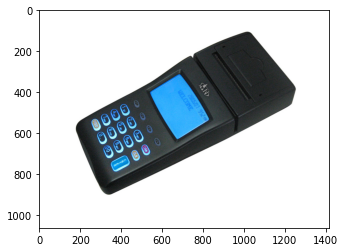

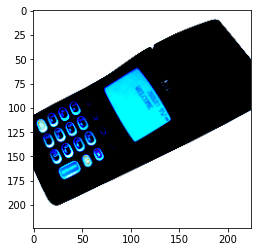

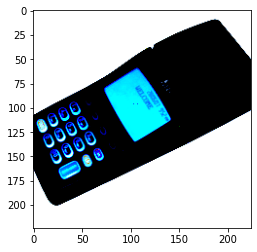

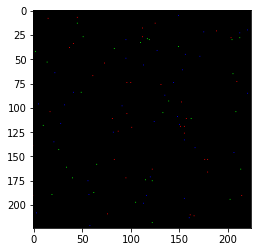

In [12]:
this_path, x, y, hist, count, iters = out_vecs[-1]

# What is the category
print(labels[y])

# How many perturbations did it take?
print(count)

# How many iterations were run?
print(iters)

# unmodified input image
plt.imshow(get_img(this_path))
plt.show()

# unmodified input image
plt.imshow(get_alexnet_img(this_path).permute(1,2,0).clamp(0,1))
plt.show()

# transformed input
plt.imshow(x.permute(1,2,0).clamp(0,1))
plt.show()

# the adversarial mask
plt.imshow(hist.reshape(224,224,3).clamp(0,1))
plt.show()

## Write list of used images + labels, option to read data back in.

In [13]:
WRITE = True
READ = False
import pickle
import shutil, os

if WRITE:
    
    # write all used image paths
    path_set = [v[0] for v in out_vecs]
    with open("./results/used_images.txt", "w") as f:
        for line in path_set:
            f.write(line.split('/')[-1])
            f.write('\n')
            
    for this_path in path_set:
        # copy the img to a holdout folder.
        shutil.copy(this_path, "./results/subset_used")
            
    # write image labels to file
    path_set = [v[2] for v in out_vecs]
    with open("./results/used_labels.txt", "w") as f:
        for line in path_set:
            f.write(str(line))
            f.write('\n') 
    
    # dump datastructure w/ perturbations to pickle
    with open("./results/sorted_outputs.p", "wb") as f:
        pickle.dump(out_vecs, f)
        
if READ:
    # grab datastructure w/ perturbations from pickle
    with open("./results/sorted_outputs.p", "rb") as f:
        out_vecs_read = pickle.load(f)
    print(labels[out_vecs_read[-1][2]])

## Statistics on the perturbation masks

In [14]:
hist_norms = [np.linalg.norm(v[3]) for v in out_vecs]

max_norm = np.max(hist_norms)
print(f"Max: {max_norm}")

avg_norm = np.mean(hist_norms)
print(f"Avg: {avg_norm}")

med_norm = np.median(hist_norms)
print(f"Med: {med_norm}")

min_norm = np.min(hist_norms)
print(f"Min: {min_norm}")

Max: 61.454349517822266
Avg: 22.601285934448242
Med: 22.314123153686523
Min: 1.1313709020614624
